In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models.resnet as resnet
import numpy as np
import torch.multiprocessing as mp

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
device
torch.set_default_device(device)

# Set the start method to 'spawn'
mp.set_start_method('spawn')

# Define Models

In [2]:
# Define an optimized CNN model
class OptimizedCNN_Model(nn.Module):
    def __init__(self, num_classes=8):
        super(OptimizedCNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # First convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Third convolutional layer

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(0.5)

        # Adjust input size of fully connected layer based on output of the convolutional layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, num_classes)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2, ReLU activation, and max pooling
        x = self.pool(F.relu(self.conv3(x)))  # Apply conv3, ReLU activation, and max pooling
        x = x.view(-1, 128 * 16 * 16)         # Flatten the tensor
        x = self.dropout(F.relu(self.fc1(x))) # Apply fc1, ReLU activation, and dropout
        x = self.fc2(x)                       # Apply fc2 to get the output
        return x

In [3]:
# Adding another convolutional layer block (total of 5 blocks)

class TinyVGG5(nn.Module):
    def __init__(self, num_classes):
        super(TinyVGG5, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 -> 64

            # Convolutional Layer Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 -> 32

            # Convolutional Layer Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

            # Convolutional Layer Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 8

            # Convolutional Layer Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8 -> 4
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [4]:
# Implement ResNet50

# Predefine
conv1x1 = resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock = resnet.BasicBlock

# Define the model
# Dataset image size is 48x48 => 128x128

class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=8, zero_init_residual=True):
        super(ResNet50, self).__init__()
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1) # Change stride size

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Load Dataset and Model

In [5]:
# Load the dataset
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

testset = torchvision.datasets.ImageFolder(root='./../fer2013plus/fer2013/test', transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2, generator=torch.Generator(device=device))

class_names = testset.classes
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


In [6]:
# Load the model
cnn = OptimizedCNN_Model(num_classes=8).to(device)
cnn.load_state_dict(torch.load('optimised_cnn.pth', map_location=torch.device(device)))

vgg = TinyVGG5(len(class_names)).to(device)
vgg.load_state_dict(torch.load('tiny_VGG.pth', map_location=torch.device(device)))

resnet50 = ResNet50(Bottleneck, [3, 4, 6, 3], num_classes=8).to(device)
resnet50.load_state_dict(torch.load('resnet_best_model.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [7]:
cnn.eval()

OptimizedCNN_Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=8, bias=True)
)

In [8]:
vgg.eval()

TinyVGG5(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 1

In [9]:
# Test the model
resnet50.eval()

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

# CNN Evaluation

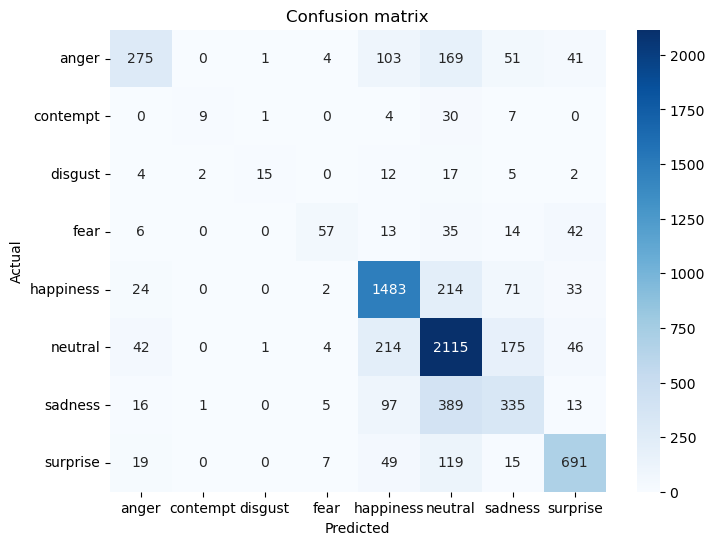

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
confusion_matrix = torch.zeros(8, 8)

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)

        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

# Convert the confusion matrix tensor to numpy
confusion_matrix_np = confusion_matrix.cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_np, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [11]:
# Show the classification report
from sklearn.metrics import classification_report

y_true = []
y_pred = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       anger       0.71      0.43      0.53       644
    contempt       0.75      0.18      0.29        51
     disgust       0.83      0.26      0.40        57
        fear       0.72      0.34      0.46       167
   happiness       0.75      0.81      0.78      1827
     neutral       0.68      0.81      0.74      2597
     sadness       0.50      0.39      0.44       856
    surprise       0.80      0.77      0.78       900

    accuracy                           0.70      7099
   macro avg       0.72      0.50      0.55      7099
weighted avg       0.70      0.70      0.69      7099



In [12]:
# ROC-AUC score
from sklearn.metrics import roc_auc_score

y_true = []
y_score = []
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn(images)
        y_true.extend(labels.cpu().numpy())
        y_score.extend(F.softmax(outputs, dim=1).cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

roc_auc = roc_auc_score(y_true, y_score, multi_class='ovo')
print(roc_auc)

0.8629883076403441


# VGG Evaluation

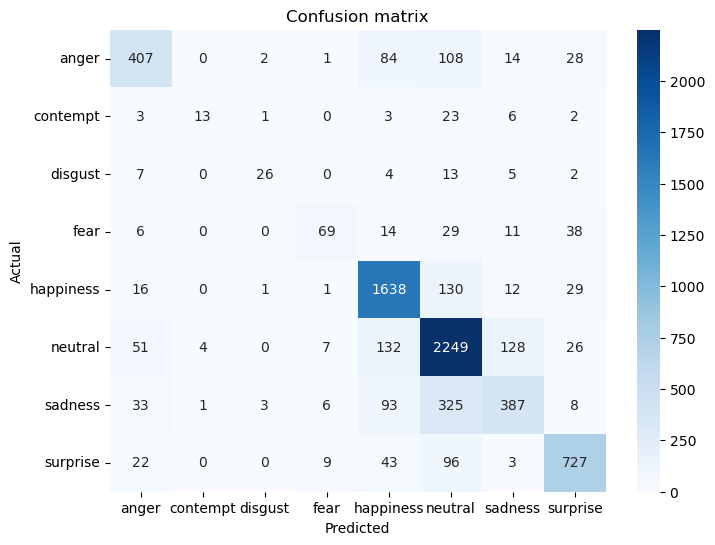

In [13]:
# Confusion matrix
confusion_matrix = torch.zeros(8, 8)

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg(images)
        _, predicted = torch.max(outputs, 1)

        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

# Convert the confusion matrix tensor to numpy
confusion_matrix_np = confusion_matrix.cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_np, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [14]:
# Show the classification report
from sklearn.metrics import classification_report

y_true = []
y_pred = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       anger       0.75      0.63      0.68       644
    contempt       0.72      0.25      0.38        51
     disgust       0.79      0.46      0.58        57
        fear       0.74      0.41      0.53       167
   happiness       0.81      0.90      0.85      1827
     neutral       0.76      0.87      0.81      2597
     sadness       0.68      0.45      0.54       856
    surprise       0.85      0.81      0.83       900

    accuracy                           0.78      7099
   macro avg       0.76      0.60      0.65      7099
weighted avg       0.77      0.78      0.77      7099



In [15]:
# ROC-AUC score
from sklearn.metrics import roc_auc_score

y_true = []
y_score = []
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg(images)
        y_true.extend(labels.cpu().numpy())
        y_score.extend(F.softmax(outputs, dim=1).cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

roc_auc = roc_auc_score(y_true, y_score, multi_class='ovo')
print(roc_auc)

0.9132998125514226


# ResNet Evaluation

/home/asm6788/anaconda3/envs/crack/lib/python3.11/site-packages/torch/utils/_device.py:78: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return func(*args, **kwargs)


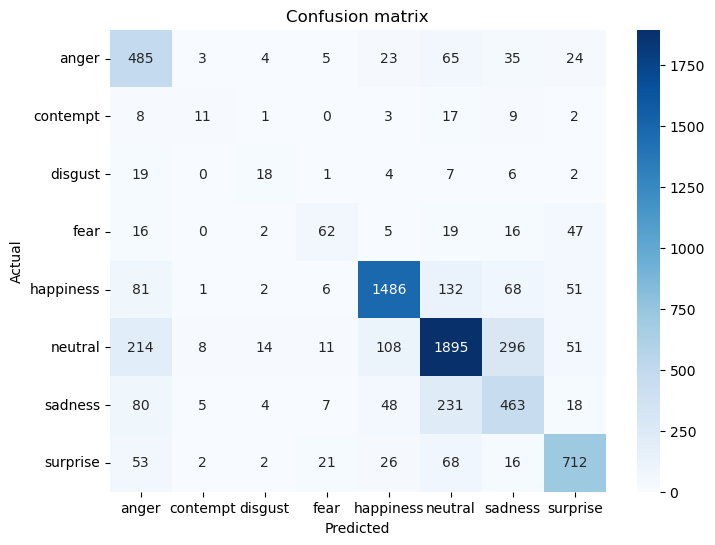

In [16]:
# Confusion matrix
confusion_matrix = torch.zeros(8, 8)

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)

        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

# Convert the confusion matrix tensor to numpy
confusion_matrix_np = confusion_matrix.cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_np, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [17]:
# Show the classification report
from sklearn.metrics import classification_report

y_true = []
y_pred = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet50(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       anger       0.51      0.75      0.61       644
    contempt       0.37      0.22      0.27        51
     disgust       0.38      0.32      0.35        57
        fear       0.55      0.37      0.44       167
   happiness       0.87      0.81      0.84      1827
     neutral       0.78      0.73      0.75      2597
     sadness       0.51      0.54      0.52       856
    surprise       0.79      0.79      0.79       900

    accuracy                           0.72      7099
   macro avg       0.59      0.57      0.57      7099
weighted avg       0.73      0.72      0.73      7099



In [18]:
# ROC-AUC score
from sklearn.metrics import roc_auc_score

y_true = []
y_score = []
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet50(images)
        y_true.extend(labels.cpu().numpy())
        y_score.extend(F.softmax(outputs, dim=1).cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

roc_auc = roc_auc_score(y_true, y_score, multi_class='ovo')
print(roc_auc)

0.890634712582821
